<a href="https://colab.research.google.com/github/SylviaaaaW/StyleCLIP_study/blob/test/StyleCLIP_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#セットアップ
3分ぐらいかかる

In [ ]:

import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

#e4e
!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

% cd
% cd /content/

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/SylviaaaaW/StyleCLIP_study.git

os.chdir(f'./{CODE_DIR}')


from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:30tcmalloc: large alloc 1147494400 bytes == 0x55fe605fe000 @  0x7f90a9870615 0x55fe279b04cc 0x55fe27a9047a 0x55fe279b32ed 0x55fe27aa4e1d 0x55fe27a26e99 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a26d00 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a23737 0x55fe27aa5c66 0x55fe27a22daf 0x55fe27aa5c66 0x55fe27a22daf 0x55fe27aa5c66 0x55fe27a22daf 0x55fe279b5039 0x55fe279f8409 0x55fe279b3c52 0x55fe27a26c25 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a23737 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a22915 0x55fe279b4afa 0x55fe27a22c0d 0x55fe27a219ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:26tcmalloc: large alloc 1434370048 bytes == 0x55fea4c54000 @  0x7f90a9870615 0x55fe279b04cc 0x55fe27a9047a 0x55fe279b32ed 0x55fe27aa4e1d 0x55fe27a26e99 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a26d00 0x55fe27a219ee 0x55fe279b4bda 0x55fe27a23737 0x

#e4e
This section can be skipped if you prefer to edit generated image.

In [ ]:
#e4e
# Upload an Image
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')


Downloading...
From: https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:08<00:00, 146MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


#Align image
image_path = /content/StyleCLIP_study/images/
000001.jpgから000016.jpg

--2021-11-10 09:42:18--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  27.2MB/s    in 2.2s    

2021-11-10 09:42:21 (27.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


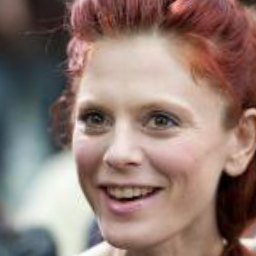

In [ ]:
#Align image
image_path = "/content/StyleCLIP_study/images/000002.jpg" #@param {type: "string"}

original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

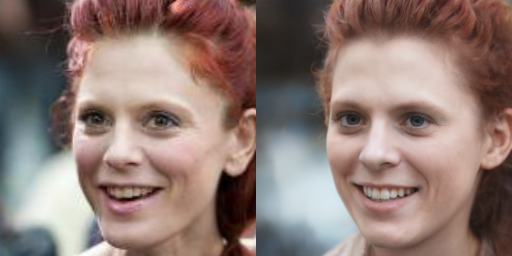

In [ ]:
#Invert the image

import os
import shutil

if os.path.isdir('vec'):
     shutil.rmtree('vec')
os.makedirs('vec', exist_ok=True)

img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, '/content/StyleCLIP_study/global_directions/vec_e4e/'+'test.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

# StyleCLIP



In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [ ]:
# input dataset name 
dataset_name='ffhq' # input dataset name, currently, only support ffhq

% cd
% cd /content/StyleCLIP_study/global_directions

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w'
!python GetCode.py --dataset_name $dataset_name --code_type 's'
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std'

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

M=Manipulator(dataset_name='ffhq')
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

image_path = None
img_index = None

/root
/content/StyleCLIP_study/global_directions
--2021-11-10 09:42:34--  https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.158.98, 52.84.158.9, 52.84.158.18, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.158.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘./model/stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   225MB/s    in 1.6s    

2021-11-10 09:42:37 (225 MB/s) - ‘./model/stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
get all z and w
Generate S
2021-11-10 09:43:19.510023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dyna

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 236MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (?, 512)             (512, 

# 画像編集

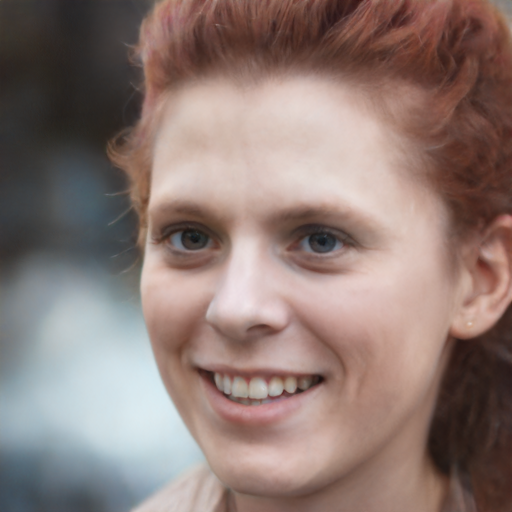

In [ ]:
# --- 画像の選択 ---

pt_folder = '/content/StyleCLIP_study/global_directions/vec_e4e/'
pt_name = 'test.pt' #@param {type:"string"}
latents=torch.load(pt_folder+pt_name)
w_plus=latents.cpu().detach().numpy()
M.dlatents=M.W2S(w_plus)

img_indexs=[0]
dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha_A=[0]
M.alpha_B=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original




In [ ]:
# --- テキスト入力A ---

neutral_A='face' #@param {type:"string"}
target_A='smiling face' #@param {type:"string"}
classnames_A=[target_A,neutral_A]
dt_A=GetDt(classnames_A,model)

0.364


In [ ]:
# --- テキスト入力B ---

neutral_B='face' #@param {type:"string"}
target_B='mad face' #@param {type:"string"}
classnames_B=[target_B,neutral_B]
dt_B=GetDt(classnames_B,model)

0.3042


num of channels being manipulated: 85


(-0.5, 1023.5, 1023.5, -0.5)

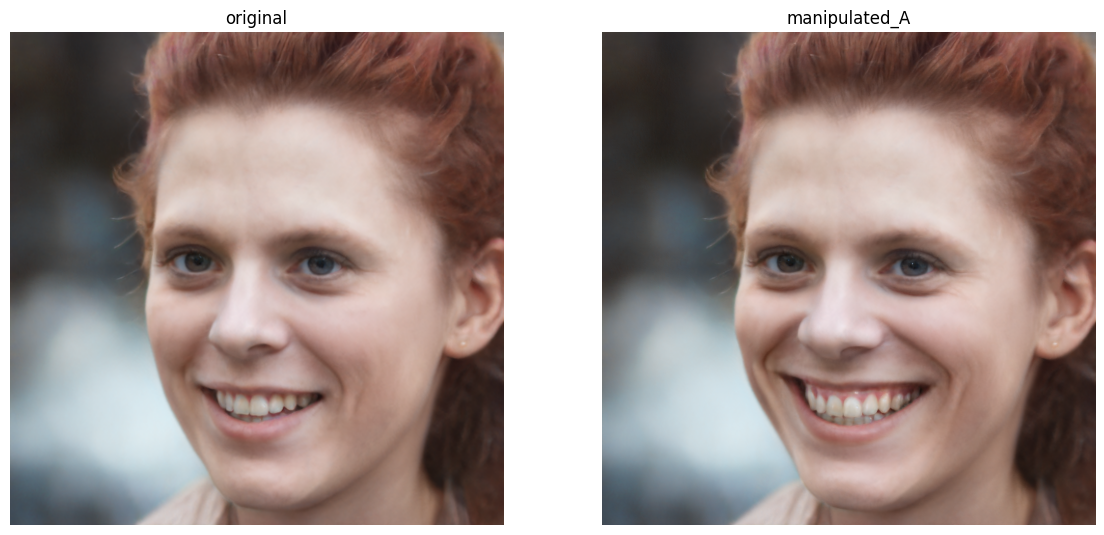

In [ ]:
# --- alpha & beta Aの設定 ---

beta_A = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha_A = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha_A]
boundary_tmp2,c=GetBoundary(fs3,dt_A,M,threshold=beta_A)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

plt.figure(figsize=(14,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated_A')
plt.axis('off')

num of channels being manipulated: 53


(-0.5, 1023.5, 1023.5, -0.5)

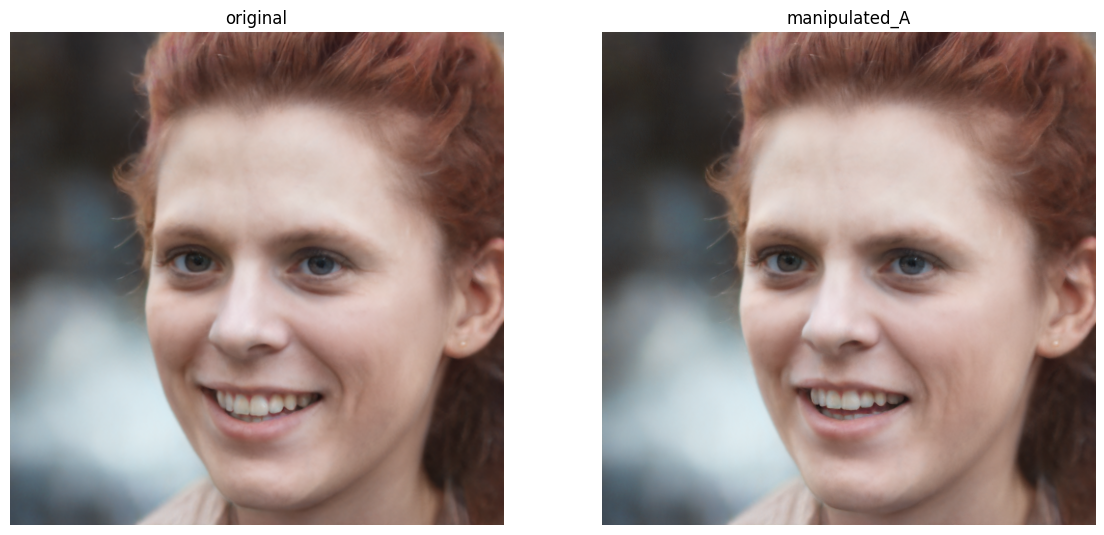

In [ ]:
# --- alpha & beta Bの設定 ---

beta_B = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha_B = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha_B]
boundary_tmp2,c=GetBoundary(fs3,dt_B,M,threshold=beta_B)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

plt.figure(figsize=(14,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated_A')
plt.axis('off')

In [ ]:
# ---二つtarget 編集画像の連続生成 ---

alpha_A = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
alpha_B = 3 #@param {type:"slider", min:-10, max:10, step:0.1}
numA = int(alpha_A*10)
numB = int(alpha_B*10)
beta = 0.1

from tqdm import trange
import os
import shutil

# pic フォルダーリセット
if os.path.isdir('pic'):
     shutil.rmtree('pic')
os.makedirs('pic', exist_ok=True)

# 画像生成関数 表情A
def generate_img_A(alpha, cnt):
     M.alpha=[alpha]
     boundary_tmp2,c=GetBoundary(fs3,dt_A,M,threshold=beta)
     codes=M.MSCode(dlatent_tmp,boundary_tmp2)
     out=M.GenerateImg(codes)
     pic = Image.fromarray(out[0,0])
     pic = pic.resize((512,512))  

     # orjinal と連結
     dst = Image.new('RGB', (original.width + pic.width, original.height))
     dst.paste(original, (0,0))
     dst.paste(pic, (original.width, 0))

     dst.save('./pic/'+str(cnt).zfill(6)+'.png') 

# 画像生成関数　表情B
def generate_img_B(alpha, cnt):
     M.alpha=[alpha]
     boundary_tmp2,c=GetBoundary(fs3,dt_B,M,threshold=beta)
     codes=M.MSCode(dlatent_tmp,boundary_tmp2)
     out=M.GenerateImg(codes)
     pic = Image.fromarray(out[0,0])
     pic = pic.resize((512,512))  

     # orjinal と連結
     dst = Image.new('RGB', (original.width + pic.width, original.height))
     dst.paste(original, (0,0))
     dst.paste(pic, (original.width, 0))

     dst.save('./pic/'+str(cnt).zfill(6)+'.png')     

cnt = 0
for i in trange(15, desc='alpha = 0'):
     generate_img_A(0, cnt)
     cnt +=1

for i in trange(0, numA, 1, desc='alpha_A = 0 -> max'):
     generate_img_A(i/10, cnt)
     cnt +=1

for i in trange(0, numA, 1, desc='alpha_A =max -> 0'):
     generate_img_A((numA-i)/10, cnt)
     cnt +=1

#for i in trange(2, desc='alpha = 0'):
#     generate_img_B(0, cnt)
#     cnt +=1

for i in trange(0, numB, 1, desc='alpha_B = 0 -> max'):
     generate_img_B(i/10, cnt)
     cnt +=1

for i in trange(0, numB, 1, desc='alpha_B = max -> 0'):
     generate_img_B((numB-i)/10, cnt)
     cnt +=1

alpha = 0:   0%|          | 0/15 [00:00<?, ?it/s]

num of channels being manipulated: 85


alpha = 0:   7%|▋         | 1/15 [00:00<00:04,  3.22it/s]

num of channels being manipulated: 85


alpha = 0:  13%|█▎        | 2/15 [00:00<00:03,  3.37it/s]

num of channels being manipulated: 85


alpha = 0:  20%|██        | 3/15 [00:00<00:03,  3.44it/s]

num of channels being manipulated: 85


alpha = 0:  27%|██▋       | 4/15 [00:01<00:03,  3.47it/s]

num of channels being manipulated: 85


alpha = 0:  33%|███▎      | 5/15 [00:01<00:02,  3.49it/s]

num of channels being manipulated: 85


alpha = 0:  40%|████      | 6/15 [00:01<00:02,  3.49it/s]

num of channels being manipulated: 85


alpha = 0:  47%|████▋     | 7/15 [00:02<00:02,  3.44it/s]

num of channels being manipulated: 85


alpha = 0:  53%|█████▎    | 8/15 [00:02<00:02,  3.47it/s]

num of channels being manipulated: 85


alpha = 0:  60%|██████    | 9/15 [00:02<00:01,  3.48it/s]

num of channels being manipulated: 85


alpha = 0:  67%|██████▋   | 10/15 [00:02<00:01,  3.49it/s]

num of channels being manipulated: 85


alpha = 0:  73%|███████▎  | 11/15 [00:03<00:01,  3.49it/s]

num of channels being manipulated: 85


alpha = 0:  80%|████████  | 12/15 [00:03<00:00,  3.49it/s]

num of channels being manipulated: 85


alpha = 0:  87%|████████▋ | 13/15 [00:03<00:00,  3.51it/s]

num of channels being manipulated: 85


alpha = 0:  93%|█████████▎| 14/15 [00:04<00:00,  3.51it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:   0%|          | 0/25 [00:00<?, ?it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:   4%|▍         | 1/25 [00:00<00:06,  3.49it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:   8%|▊         | 2/25 [00:00<00:07,  3.16it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  12%|█▏        | 3/25 [00:00<00:07,  3.01it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  16%|█▌        | 4/25 [00:01<00:07,  2.93it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  20%|██        | 5/25 [00:01<00:06,  2.89it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  24%|██▍       | 6/25 [00:02<00:06,  2.87it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  28%|██▊       | 7/25 [00:02<00:06,  2.86it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  32%|███▏      | 8/25 [00:02<00:05,  2.86it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  36%|███▌      | 9/25 [00:03<00:05,  2.85it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  40%|████      | 10/25 [00:03<00:05,  2.83it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  44%|████▍     | 11/25 [00:03<00:04,  2.83it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  48%|████▊     | 12/25 [00:04<00:04,  2.82it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  52%|█████▏    | 13/25 [00:04<00:04,  2.81it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  56%|█████▌    | 14/25 [00:04<00:03,  2.79it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  60%|██████    | 15/25 [00:05<00:03,  2.76it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  64%|██████▍   | 16/25 [00:05<00:03,  2.76it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  68%|██████▊   | 17/25 [00:05<00:02,  2.77it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  72%|███████▏  | 18/25 [00:06<00:02,  2.76it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  76%|███████▌  | 19/25 [00:06<00:02,  2.77it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  80%|████████  | 20/25 [00:07<00:01,  2.76it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  84%|████████▍ | 21/25 [00:07<00:01,  2.75it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  88%|████████▊ | 22/25 [00:07<00:01,  2.76it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  92%|█████████▏| 23/25 [00:08<00:00,  2.71it/s]

num of channels being manipulated: 85


alpha_A = 0 -> max:  96%|█████████▌| 24/25 [00:08<00:00,  2.71it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:   0%|          | 0/25 [00:00<?, ?it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:   4%|▍         | 1/25 [00:00<00:08,  2.79it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:   8%|▊         | 2/25 [00:00<00:08,  2.78it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  12%|█▏        | 3/25 [00:01<00:08,  2.73it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  16%|█▌        | 4/25 [00:01<00:07,  2.74it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  20%|██        | 5/25 [00:01<00:07,  2.76it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  24%|██▍       | 6/25 [00:02<00:06,  2.74it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  28%|██▊       | 7/25 [00:02<00:06,  2.74it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  32%|███▏      | 8/25 [00:02<00:06,  2.68it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  36%|███▌      | 9/25 [00:03<00:05,  2.69it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  40%|████      | 10/25 [00:03<00:05,  2.72it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  44%|████▍     | 11/25 [00:04<00:05,  2.72it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  48%|████▊     | 12/25 [00:04<00:04,  2.74it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  52%|█████▏    | 13/25 [00:04<00:04,  2.71it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  56%|█████▌    | 14/25 [00:05<00:04,  2.73it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  60%|██████    | 15/25 [00:05<00:03,  2.74it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  64%|██████▍   | 16/25 [00:05<00:03,  2.75it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  68%|██████▊   | 17/25 [00:06<00:02,  2.73it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  72%|███████▏  | 18/25 [00:06<00:02,  2.73it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  76%|███████▌  | 19/25 [00:06<00:02,  2.73it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  80%|████████  | 20/25 [00:07<00:01,  2.75it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  84%|████████▍ | 21/25 [00:07<00:01,  2.75it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  88%|████████▊ | 22/25 [00:08<00:01,  2.77it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  92%|█████████▏| 23/25 [00:08<00:00,  2.79it/s]

num of channels being manipulated: 85


alpha_A =max -> 0:  96%|█████████▌| 24/25 [00:08<00:00,  2.80it/s]

num of channels being manipulated: 85


alpha_B = 0 -> max:   0%|          | 0/30 [00:00<?, ?it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:   3%|▎         | 1/30 [00:00<00:08,  3.53it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:   7%|▋         | 2/30 [00:00<00:08,  3.14it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  10%|█         | 3/30 [00:00<00:09,  2.99it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  13%|█▎        | 4/30 [00:01<00:08,  2.92it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  17%|█▋        | 5/30 [00:01<00:08,  2.86it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  20%|██        | 6/30 [00:02<00:08,  2.85it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  23%|██▎       | 7/30 [00:02<00:08,  2.84it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  27%|██▋       | 8/30 [00:02<00:07,  2.83it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  30%|███       | 9/30 [00:03<00:07,  2.81it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  33%|███▎      | 10/30 [00:03<00:07,  2.80it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  37%|███▋      | 11/30 [00:03<00:06,  2.81it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  40%|████      | 12/30 [00:04<00:06,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  43%|████▎     | 13/30 [00:04<00:06,  2.78it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  47%|████▋     | 14/30 [00:04<00:05,  2.77it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  50%|█████     | 15/30 [00:05<00:05,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  53%|█████▎    | 16/30 [00:05<00:05,  2.78it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  57%|█████▋    | 17/30 [00:05<00:04,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  60%|██████    | 18/30 [00:06<00:04,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  63%|██████▎   | 19/30 [00:06<00:03,  2.78it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  67%|██████▋   | 20/30 [00:07<00:03,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  70%|███████   | 21/30 [00:07<00:03,  2.80it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  73%|███████▎  | 22/30 [00:07<00:02,  2.79it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  77%|███████▋  | 23/30 [00:08<00:02,  2.75it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  80%|████████  | 24/30 [00:08<00:02,  2.73it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  83%|████████▎ | 25/30 [00:08<00:01,  2.74it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  87%|████████▋ | 26/30 [00:09<00:01,  2.75it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  90%|█████████ | 27/30 [00:09<00:01,  2.76it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  93%|█████████▎| 28/30 [00:09<00:00,  2.73it/s]

num of channels being manipulated: 53


alpha_B = 0 -> max:  97%|█████████▋| 29/30 [00:10<00:00,  2.73it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:   0%|          | 0/30 [00:00<?, ?it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:   3%|▎         | 1/30 [00:00<00:10,  2.76it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:   7%|▋         | 2/30 [00:00<00:10,  2.76it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  10%|█         | 3/30 [00:01<00:09,  2.77it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  13%|█▎        | 4/30 [00:01<00:09,  2.78it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  17%|█▋        | 5/30 [00:01<00:08,  2.79it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  20%|██        | 6/30 [00:02<00:08,  2.77it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  23%|██▎       | 7/30 [00:02<00:08,  2.79it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  27%|██▋       | 8/30 [00:02<00:08,  2.63it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  30%|███       | 9/30 [00:03<00:07,  2.65it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  33%|███▎      | 10/30 [00:03<00:07,  2.67it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  37%|███▋      | 11/30 [00:04<00:07,  2.71it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  40%|████      | 12/30 [00:04<00:06,  2.71it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  43%|████▎     | 13/30 [00:04<00:06,  2.65it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  47%|████▋     | 14/30 [00:05<00:06,  2.65it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  50%|█████     | 15/30 [00:05<00:05,  2.68it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  53%|█████▎    | 16/30 [00:05<00:05,  2.68it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  57%|█████▋    | 17/30 [00:06<00:04,  2.68it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  60%|██████    | 18/30 [00:06<00:04,  2.70it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  63%|██████▎   | 19/30 [00:07<00:04,  2.71it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  67%|██████▋   | 20/30 [00:07<00:03,  2.74it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  70%|███████   | 21/30 [00:07<00:03,  2.75it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  73%|███████▎  | 22/30 [00:08<00:02,  2.77it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  77%|███████▋  | 23/30 [00:08<00:02,  2.76it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  80%|████████  | 24/30 [00:08<00:02,  2.71it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  83%|████████▎ | 25/30 [00:09<00:01,  2.73it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  87%|████████▋ | 26/30 [00:09<00:01,  2.75it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  90%|█████████ | 27/30 [00:09<00:01,  2.76it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  93%|█████████▎| 28/30 [00:10<00:00,  2.74it/s]

num of channels being manipulated: 53


alpha_B = max -> 0:  97%|█████████▋| 29/30 [00:10<00:00,  2.75it/s]

num of channels being manipulated: 53


alpha_B = max -> 0: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


In [ ]:
# --- mp4動画の作成 ---

# 既に output.mp4 があれば削除する
import os
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# pic フォルダの画像から動画を生成
! ffmpeg -r 30 -i pic/%6d.png\
               -vcodec libx264 -pix_fmt yuv420p output.mp4

# movieフォルダへ名前を付けてコピー
import shutil
os.makedirs('movie', exist_ok=True)
shutil.copy('output.mp4', 'movie/'+target_B+'_'+pt_name[:-3]+'.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

'movie/mad face_test.mp4'

In [ ]:
# --- mp4動画の再生 ---

from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")